<h1 style="text-align: center;">Support Vector Machines</h1>

The aim of this lab is to get hands-on experience with implementing and using support vector machines

In [1]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import random
import math
import matplotlib.patches as mpatches

### Generating Test Data
Generation of two-dimensional data, i.e., points in a plane. The data will have the form of N x 2 Array.


In [2]:
#np.random.seed(100)    # to get the same random numbers

classA = np.concatenate(
    (np.random.randn(10, 2) * 0.2 + [1.5, 0.5],
    np.random.randn(10, 2) * 0.2 + [-1.5, 0.5]))
classB = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

N = inputs.shape[0]   # Number of rows (samples)

permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

### Kernels definition

In [3]:
def LinearKernel(x, y):
    return np.dot(x, y)

def PolynomialKernel(x, y, p=3):
    '''Optional parameter p controls the degree of the polynomial'''
    return (1 + np.dot(x, y)) ** p

def RBFKernel(x, y, sigma=1.0):
    '''Optional parameter sigma controls the width of the Gaussian'''
    return math.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

Kernel = RBFKernel

### SVM implementation

Generation of the Pmatrix, needed in function `objective`. This matrix is computed outside the function for efficiency reasons.

In [4]:
Pmatrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Pmatrix[i, j] = targets[i] * targets[j] * Kernel(inputs[i], inputs[j])

Implement the function `objective`, which implements the formula needed for the *dual problem* formulation.
The dual problem is used since it meakes possible to use the *kernel trick*.

In [5]:
def objective(alpha):
    '''Implement expression (4)'''
    return 0.5 * np.dot(alpha, np.dot(alpha, Pmatrix)) - np.sum(alpha)

Implement the function `nonzero`, which implements the equality constraint. 

In [6]:
def zerfun(alpha):
    '''Implement expression (10), i.e., the equality constraint'''
    return np.dot(alpha, targets)

Call the `minimize` function from the `scipy.optimize` package, which will find and return the vector which minimize the function *objective* within the bounds *B* and the constraints *XC* 

In [7]:
'''Initial guess of alpha'''
start = np.zeros(N)

'''Set B, i.e., the bounds for alpha vector'''

#B = [(0, None) for b in range(N)]  for having only lower bound

C = 10000
B = [(0, C) for b in range(N)]  # for having both lower and upper bounds

'''Set the constraint, in this case the zerofun function. XC is given as a dictionary'''
XC = {'type':'eq', 'fun':zerfun}

'''Call to minimize function'''
ret = minimize(objective, start, bounds=B, constraints=XC)

if (not ret['success']):    # success is a Boolean flag indicating if the optimizer exited successfully
    raise ValueError('Cannot find optimal solution')

alpha = ret['x']    # x is the solution array

Only few elements of the alpha vector will be non-zero. Those non-zero values are ours Support Vectors, hence we save them in a separate data structure.

In [8]:
# extract non-zero alphas

nonzero = [(alpha[i], inputs[i], targets[i]) for i in range(N) if abs(alpha[i]) > 1e-5]

Calculation of the *b* threshold, needed in the function `indicator`.

In [9]:
def bvalue():
    '''Implement expression (7)'''
    sum = 0
    for value in nonzero:
        sum += value[0] * value[2] * Kernel(value[1], nonzero[0][1])
    return sum - nonzero[0][2]

Implement the function `indicator`, which classifies new data points.

In [10]:
def indicator(x, y):
    '''Implement expression (6)'''
    sum = 0
    for value in nonzero:
        sum += value[0] * value[2] * Kernel(value[1], [x, y])
    return sum - bvalue()

Plot the results of the classification. The points are colored according to their class. The Support Vectors are marked with a green cross.

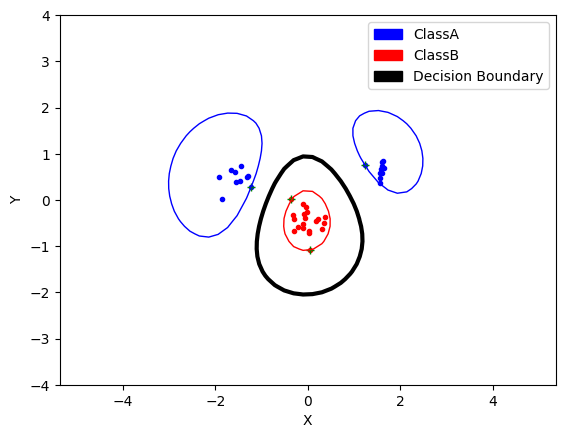

In [11]:
# Plot data points

plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
plt.plot([p[1][0] for p in nonzero], [p[1][1] for p in nonzero], 'g+')
plt.axis('equal')   # set the axes to the same scale

# Plot the decision boundary

xgrid = np.linspace(-5, 5)
ygrid = np.linspace(-4, 4)
grid = np.array([[indicator(x, y) for x in xgrid] for y in ygrid])
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

blue_patch = mpatches.Patch(color='blue', label='ClassA')
red_patch = mpatches.Patch(color='red', label='ClassB')
black_patch = mpatches.Patch(color='black', label='Decision Boundary')
plt.legend(handles=[blue_patch, red_patch, black_patch])

plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('resources/svmplot.png')  # save a copy in a file
plt.show()

### Exploring and Reporting

#### Question n.1
Move the cluster around and change their sizes to make it easier or harder for the classifier to find a decent boundary. Pay attention to when the optimizer is not able to find a solution at all.  


We modify C, which allows more or less slack and the deviation in the data point generation
In the following images I used C = 10 and the deviation = 0.1,0.2,0.5,0.8

C = 10 D = 0.1             |  C = 10 D = 0.2
:-------------------------:|:-------------------------:
![](resources/C10D0-1.png)  |  ![](resources/C10D0-2.png)
C = 10 D = 0.5             |  C = 10 D = 0.8
![](resources/C10D0-5.png)  |  ![](resources/C10D0-8.png)


The optimizer is not able to find an optimal solution when the data are no more linearly separable, i.e., with high C (few slack allowed) and high deviation in the data generation.

#### Question n.2
Implement the two non linear kernels. You should be able to classify very hard data sets with these.

Polynomial C = 10 D = 0.5             |  RBF C = 10 D = 0.8
:-------------------------:|:-------------------------:
![](resources/PolyC10D0.5.png)  |  ![](resources/RBFC10D0.8.png)

We can see that even these two hard data sets are almost perfectly classified.

#### Question n.3
The non-linear kernels have parameters; explore how they influence the decision boundary. Reason about this in terms of the bias-variance tradde-off

1. Polynomial kernel
    - P: grade of the polynomial
    - High P: complex curve &#8594; overfitting &#8594; high variance, low bias
    - Low P: simple curve &#8594; underfitting &#8594; low variance, high bias

2. RBF kernel
    - Sigma: smoothness of the boundary
    - Low sigma: rough decision boundary &#8594; overfitting &#8594; high variance, low bias
    - High sigma: smooth decision boundary &#8594; underfitting &#8594; low variance, high bias

Polynomial C = 10 D = 0.5 P = 2             |  Polynomial C = 10 D = 0.5 P = 5
:-------------------------:|:-------------------------:
![](resources/PolyP2.png)  |  ![](resources/PolyP5.png)
RBF C = 10 D = 0.5 sigma = 0.5             |  RBF C = 10 D = 0.5 sigma = 1.0
![](resources/RBFS0.3.png)  |  ![](resources/RBFS1.0.png)

#### Question n.4
Explore the role of the slack parameter C. What happens for very large/small values ?

The parameter C sets the relative importance of avoiding slacks versus getting a wider margin.
- Low C value: the margin is wider, allows more slacks. More misclassification.
- High C value: the margin is narrower, allows less slacks. Less misclassification.

Linear C = 0.1 D = 0.2             |  Linear C = 1 D = 0.2  
:-------------------------:|:-------------------------:
![](resources/LinearC0.1.png)  |  ![](resources/LinearC1.png)
Linear C = 10 D = 0.2               |  Linear C = 1000 D = 0.2
![](resources/LinearC10.png)  |  ![](resources/LinearC1000.png)

#### Question n.5
Imagine that your are given data that is not easily separable. When should you opt for more slack rather than going for a more complex model (kernel) and viceversa?

Given deviation equal to 0.1, data are not easily separable.

In low-dimension data this can be done visually. If the data points look like they should be separated by a line, but there are some outliers, it is probably more relevant to use a linear (less complex) kernel and allow for more slack. However, the more complex distribution of data points, the more relevant it is to use a more complex model. In other words, slack is mostly useful in the case of a small number of outliers which prevents the use of an otherwise well-suited model.
With complex data distributions we can reach a solution by combining a more complex model with a low slack value.

Linear C = 10 D = 0.2 (more slack)             |  RBF C = 1000 D = 0.5 (more complex model)
:-------------------------:|:-------------------------:
![](resources/MoreSlack.png)  |  ![](resources/MoreComplex.png)








